In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=bed6e5d67ec4c831e3ec23439425429fa43930ed4be46515e3e96856856f0416
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)

In [4]:
from pyspark.ml.linalg import Vectors
import re
import os


spark = SparkSession.builder.getOrCreate()
file_path = r"embedding_.csv"
df = pd.read_csv(file_path, encoding='utf-8-sig')
df.columns = ["index", "embedding"]

import torch
from torch.nn.utils.rnn import pad_sequence

df['embedding'] = df['embedding'].apply(lambda x: re.sub(r'[^\d\.\-\s]', '', x))
df['embedding'] = df['embedding'].apply(lambda x: torch.tensor(list(map(float, x.split())), dtype=torch.float))
embeddings = [x for x in df['embedding']]
padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
df['embedding'] = [x.tolist() for x in padded_embeddings]

idx_df = pd.DataFrame(df['index'])
em_df = pd.DataFrame(df['embedding'])
em_df.columns = ['features']
em_df = spark.createDataFrame(em_df)
vectors = em_df.rdd.map(lambda row: Vectors.dense(row['features']))
features = spark.createDataFrame(vectors.map(lambda x: Row(embedding=x)), ["features"])

features.show()

+--------------------+
|            features|
+--------------------+
|[-0.0323636010289...|
|[-0.0323776714503...|
|[-0.0324402488768...|
|[-0.0320736505091...|
|[-0.0323569290339...|
|[-0.0321501791477...|
|[-0.0322901904582...|
|[-0.0323294885456...|
|[-0.0323832184076...|
|[-0.0322378389537...|
|[-0.0323300212621...|
|[-0.0320815108716...|
|[-0.0324355289340...|
|[-0.0323232710361...|
|[-0.0324485190212...|
|[-0.0322582200169...|
|[-0.0322948694229...|
|[-0.0321577489376...|
|[-0.0321414396166...|
|[-0.0323349982500...|
+--------------------+
only showing top 20 rows



In [6]:
def kmeans_silhouette_layer(data):
    cost = np.zeros(8)
    silhouette_scores = []
    for k in range(2, 10):
       kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
       model = kmeans.fit(data)
       predictions = model.transform(data)
       evaluator = ClusteringEvaluator()
       val = evaluator.evaluate(predictions)
       cost[k - 2] = val
       silhouette_scores.append([k, val])
    return cost , silhouette_scores

In [7]:
cost , silhouette_scores = kmeans_silhouette_layer(features)

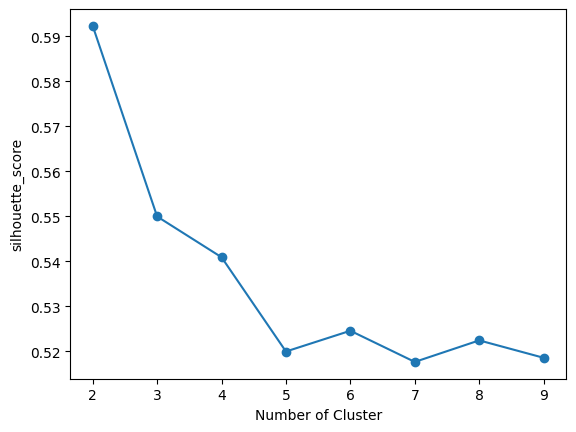

In [11]:
plt.plot(range(2, 10), cost, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('silhouette_score')
plt.show()

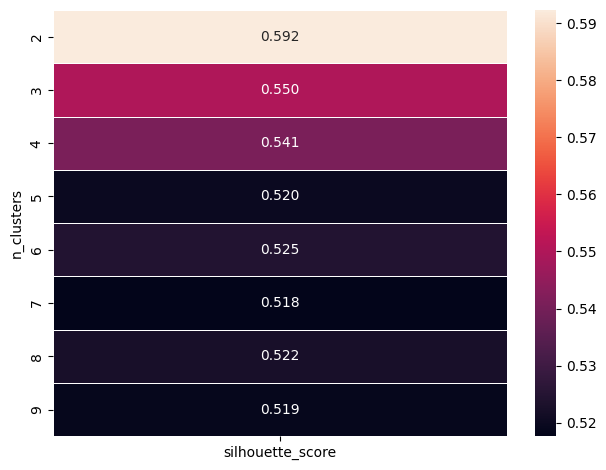

In [10]:
import seaborn as sns

result = pd.DataFrame(silhouette_scores, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

plt.figure()
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
plt.tight_layout()
plt.show()

In [7]:
def kmeans_silhouette_layer(data):
    cost = np.zeros(11)
    silhouette_scores = []
    for k in range(10, 21):
       kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
       model = kmeans.fit(data)
       predictions = model.transform(data)
       evaluator = ClusteringEvaluator()
       val = evaluator.evaluate(predictions)
       cost[k - 10] = val
       silhouette_scores.append([k, val])
    return cost , silhouette_scores

In [10]:
cost , silhouette_scores = kmeans_silhouette_layer(features)

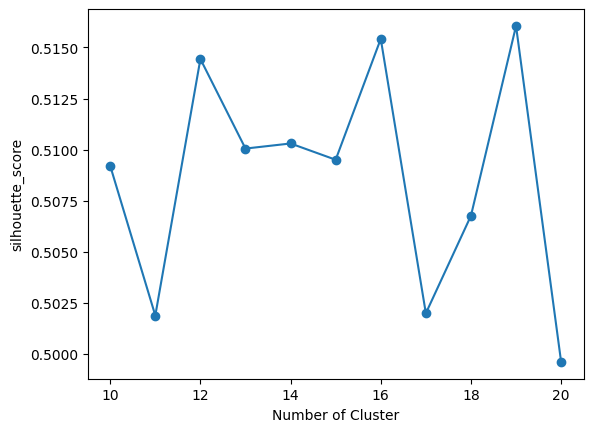

In [12]:
plt.plot(range(10, 21), cost, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('silhouette_score')
plt.show()

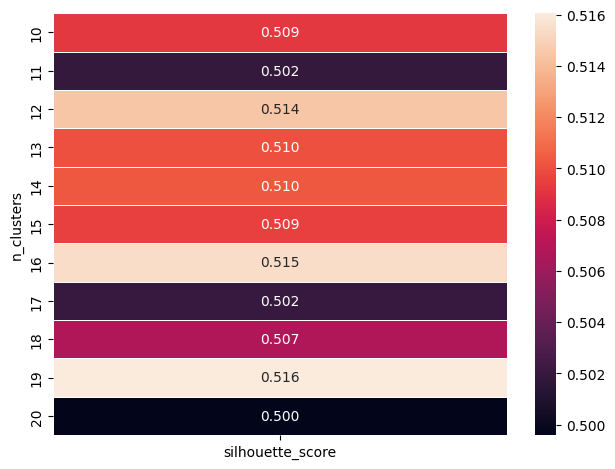

In [13]:
import seaborn as sns

result = pd.DataFrame(silhouette_scores, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

plt.figure()
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
plt.tight_layout()
plt.show()